In [262]:
import numpy as np
import math
from numba import jit

JIT decorator optimized ssvd

In [263]:
@jit
def thresh_jit(z,delta):
    return np.sign(z)*(np.abs(z) >= delta)*(np.abs(z)-delta)

In [264]:
def ssvd_jit(X, gamma_u = 2, gamma_v = 2, merr = 10**(-4), niter = 100):
    #rank 1
    U,s,V=np.linalg.svd(X)#initial svd
    u0 = U.T[0] 
    v0 = V.T[0]
    n=X.shape[0]
    d=X.shape[1]
    ud = 1
    vd = 1
    iters = 0
    SST = np.sum(X*X)

    while (ud > merr or vd > merr):
        iters =iters+1

        #update v
        z=X.T @ u0#initial OLS estimator (of the coefficients)
        w_v_inv=np.abs(z) ** gamma_v#inverse of adapative weight 
        sig_sq=np.abs(SST-np.sum(z*z))/(n*d-d)#OLS estimate of the error variance
        tmp=z*w_v_inv
        tv=np.unique(np.sort(np.append(np.abs(tmp),0)))#possible lambda set
        Bv = np.ones(len(tv)-1)*np.Inf
        index=np.where(w_v_inv>10^-8)
        tmp1=tmp[index]
        w_v_inv1=w_v_inv[index]
        for i in range(len(Bv)):
            temp2 = thresh_jit(tmp1,delta = tv[i])
            temp2 = temp2/w_v_inv1
            temp3 = np.zeros(d)
            temp3[index] = temp2
            Bv[i] = np.sum((X - u0[:,None] @ temp3[None,:])**2)/sig_sq + np.sum(temp2!=0)*math.log(n*d)
        Iv = min(np.where(Bv== np.min(Bv)))
        th = tv[Iv]
        temp2 = thresh_jit(tmp1,delta = th)
        temp2 = temp2/w_v_inv1
        v1 = np.zeros(d)
        v1[index] = temp2
        v1 = v1/((np.sum(v1*v1))**0.5) #v_new

        #update v
        z=X @ v1#initial OLS estimator (of the coefficients)
        w_u_inv=np.abs(z) ** gamma_u#inverse of adapative weight 
        sig_sq=np.abs(SST-np.sum(z*z))/(n*d-n)#OLS estimate of the error variance
        tmp=z*w_u_inv
        tv=np.unique(np.sort(np.append(np.abs(tmp),0)))#possible lambda set
        Bu = np.ones(len(tv)-1)*np.Inf
        index=np.where(w_u_inv>10^-8)
        tmp1=tmp[index]
        w_u_inv1=w_u_inv[index]
        for i in range(len(Bu)):
            temp2 = thresh_jit(tmp1,delta = tv[i])
            temp2 = temp2/w_u_inv1
            temp3 = np.zeros(n)
            temp3[index] = temp2
            Bu[i] =  np.sum((X - temp3[:,None] @ v1[None,:])**2)/sig_sq + np.sum(temp2!=0)*math.log(n*d)
        Iu = min(np.where(Bu== np.min(Bu)))
        th = tv[Iu]
        temp2 = thresh_jit(tmp1,delta = th)
        temp2 = temp2/w_u_inv1
        u1 = np.zeros(n)
        u1[index] = temp2
        u1 = u1/((np.sum(u1*u1))**0.5) #u_new

        ud = np.sum((u0-u1)*(u0-u1))**0.5
        vd = np.sum((v0-v1)*(v0-v1))**0.5

        if iters > niter :
            print("Fail to converge! Increase the niter!")
            break

        u0 = u1
        v0 = v1

    s = u1[None, :] @ X @ v1[:, None]
    return u1, v1, s, iters

Application to real data sets

In [265]:
#first we try to apply the SSVD to the lung cancer data set in the paper
#and try to reproduce the image generated in the paper.
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time

In [266]:
#import data set
data = np.loadtxt("data.txt", dtype = "float", delimiter = " ")
X=data.T

In [271]:
#perform ssvd on X and the residuals to extract the first three layers
#save the extracted layers for convience

#1st ssvd
res1=ssvd_jit(X)
#1st layer: X*=s_1*u_1(n x 1)*v_1(1 x d)
X_star_1=res1[2]*res1[0][:,None]*res1[1][None,:]
np.savetxt('l1',X_star_1)

#2nd ssvd
res2=ssvd_jit(X-l1)
#2nd layer: X*=s_2*u_2(n x 1)*v_2(1 x d)
X_star_2=res2[2]*res2[0][:,None]*res2[1][None,:]
np.savetxt('l2',X_star_2)

#3rd ssvd
res3=ssvd_jit(X-l1-l2,merr=10**(-2))
#3rd layer: X*=s_3*u_3(n x 1)*v_3(1 x d)
X_star_3=res3[2]*res3[0][:,None]*res3[1][None,:]
np.savetxt('l3',X_star_3)

In [272]:
#load the saved layers, load the saved file if want
#l1 = np.loadtxt("l1", dtype = ,float", delimiter = " ")
#l2 = np.loadtxt("l2", dtype = "float", delimiter = " ")
#l3 = np.loadtxt("l3", dtype = "float", delimiter = " ")

# all entries of the layers are first divided by 
# the maximum absolute value of the entries from all three layers
Max=np.max(np.array([np.max(np.abs(l1)),np.max(np.abs(l2)),np.max(np.abs(l3))]))
l1_scaled=X_star_1/Max
l2_scaled=X_star_2/Max
l3_scaled=X_star_3/Max

#sort the coloumn of each layer based on an ascending ordering of v
l1_sorted=l1_scaled[:,np.argsort(res1[1])]
l2_sorted=l2_scaled[:,np.argsort(res2[1])]
l3_sorted=l3_scaled[:,np.argsort(res3[1])]


In [273]:
#the information of the types of cancer is not used in the algorithm 
#but is used for interpretation of the checkboard patterns of the generated matrix approximation.
#from the readme file, we know that among the 56 cases: the rows are arranged as following:Carcinoid:1-20;
#Colon:21:33; Normal:34-50; SmallCell:51-56

#then we want to rearrange the rows for each cancer type in each layer based on u
index_row_1=np.concatenate((np.argsort(res1[0][:20]),np.argsort(res1[0][21:34])+20
                            ,np.argsort(res1[0][34:51])+33,np.argsort(res1[0][51:])+51),axis=0)

index_row_2=np.concatenate((np.argsort(res2[0][:20]),np.argsort(res2[0][21:34])+20
                            ,np.argsort(res2[0][34:51])+33,np.argsort(res2[0][51:])+51),axis=0)

index_row_3=np.concatenate((np.argsort(res3[0][:20]),np.argsort(res3[0][21:34])+20
                            ,np.argsort(res3[0][34:51])+33,np.argsort(res3[0][51:])+51),axis=0)

l1_plot=l1_sorted[index_row_1,:]
l2_plot=l2_sorted[index_row_2,:]
l3_plot=l3_sorted[index_row_3,:]

#also, 8000 genes in the middle white area are excluded, otherwise the plot woudl be too long
l1_deleted=np.delete(l1_plot,np.arange(1463,1463+8000,1),1)
l2_deleted=np.delete(l2_plot,np.arange(1489,1489+8000,1),1)
l3_deleted=np.delete(l3_plot,np.arange(695,695+8000,1),1)

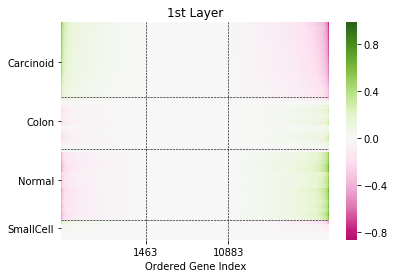

In [275]:
img1 = sns.heatmap(l1_deleted,xticklabels=False, yticklabels=False,center=0,cmap="PiYG")
img1.set(xlabel = "Ordered Gene Index", ylabel = "") 
plt.plot(list(img1.get_xlim()), [50,50], 'k--', linewidth = 0.6)
plt.plot(list(img1.get_xlim()), [32,32], 'k--', linewidth = 0.6)
plt.plot(list(img1.get_xlim()), [19,19], 'k--', linewidth = 0.6)
plt.plot([1462, 1462], list(img1.get_ylim()), 'k--', linewidth = 0.6)
plt.plot([10882-8000, 10882-8000], list(img1.get_ylim()), 'k--', linewidth = 0.6)
plt.yticks([52,40,25,10], ["SmallCell", "Normal", "Colon", "Carcinoid"])
plt.xticks([1462, 10882-8000], ["1463", "10883"])
plt.title("1st Layer")
pass
plt.savefig('l1.jpg')

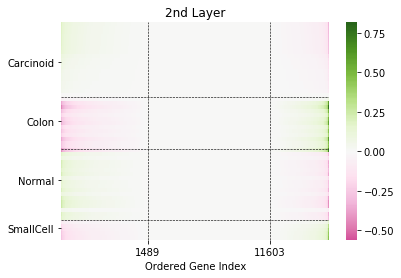

In [276]:
img2 = sns.heatmap(l2_deleted,xticklabels=False, yticklabels=False,center=0,cmap="PiYG")
img2.set(xlabel = "Ordered Gene Index", ylabel = "") 
plt.plot(list(img2.get_xlim()), [50,50], 'k--', linewidth = 0.6)
plt.plot(list(img2.get_xlim()), [32,32], 'k--', linewidth = 0.6)
plt.plot(list(img2.get_xlim()), [19,19], 'k--', linewidth = 0.6)
plt.plot([1489, 1489], list(img2.get_ylim()), 'k--', linewidth = 0.6)
plt.plot([11603-8000, 11603-8000], list(img2.get_ylim()), 'k--', linewidth = 0.6)
plt.yticks([52,40,25,10], ["SmallCell", "Normal", "Colon", "Carcinoid"])
plt.xticks([1489, 11603-8000], ["1489", "11603"])
plt.title("2nd Layer")
pass
plt.savefig('l2.jpg')

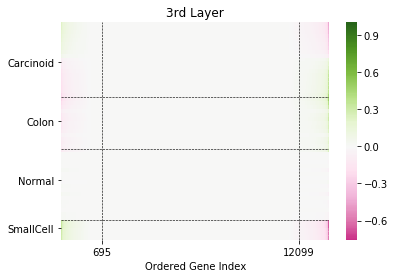

In [277]:
img3 = sns.heatmap(l3_deleted,xticklabels=False, yticklabels=False,center=0,cmap="PiYG")
img3.set(xlabel = "Ordered Gene Index", ylabel = "") 
plt.plot(list(img3.get_xlim()), [50,50], 'k--', linewidth = 0.6)
plt.plot(list(img3.get_xlim()), [32,32], 'k--', linewidth = 0.6)
plt.plot(list(img3.get_xlim()), [19,19], 'k--', linewidth = 0.6)
plt.plot([695, 695], list(img3.get_ylim()), 'k--', linewidth = 0.6)
plt.plot([12099-8000, 12099-8000], list(img3.get_ylim()), 'k--', linewidth = 0.6)
plt.yticks([52,40,25,10], ["SmallCell", "Normal", "Colon", "Carcinoid"])
plt.xticks([695, 12099-8000], ["695", "12099"])
plt.title("3rd Layer")
pass
plt.savefig('l3.jpg')

In [279]:
#load data set
new = np.loadtxt("pro.txt", dtype = "float", delimiter = " ")
X=new.T

In [280]:
X.shape

(102, 339)

In [281]:
X

array([[ 10. , 130.1, 412.6, ..., 506.3, 765.5,  30. ],
       [201. , 488. , 547. , ..., 901. , 803. , 216. ],
       [ 10. ,  13. ,  28. , ..., 108. ,  10. ,  10. ],
       ...,
       [405. , 649. , 980. , ...,  82. , 542. , 198. ],
       [238. , 280. , 695. , ..., 598. , 786. , 334. ],
       [243. , 616. , 616. , ..., 148. , 997. , 181. ]])

In [282]:
np.max(X)

15753.0

In [283]:
np.min(X)

10.0

In [284]:
#the first singular value is much larger than the other, so 1st layer
U,s,V=np.linalg.svd(X)
s

array([97138.51178757, 45036.80110527, 22298.9436974 , 17363.84199194,
       13005.7494972 ,  9498.64885526,  6464.88200017,  5829.91990071,
        5184.25838971,  5051.0286632 ,  5012.98939558,  4772.66572412,
        4528.86740364,  4220.09289558,  3818.62323361,  3666.01390514,
        3441.50178872,  3385.38365003,  3310.67792144,  3202.73245813,
        3017.16504737,  2880.05706701,  2735.42554256,  2550.5933535 ,
        2525.38622315,  2405.41597061,  2337.8844811 ,  2228.65371874,
        2163.85399836,  2042.96095005,  1984.90404713,  1925.29021263,
        1895.40506187,  1853.56577051,  1791.99956371,  1739.52125331,
        1671.11487637,  1615.12486068,  1589.49729228,  1561.01266562,
        1516.97305442,  1479.72153563,  1450.31154207,  1428.28920653,
        1396.98416318,  1372.80761113,  1350.26712028,  1309.15050531,
        1298.8072786 ,  1270.08507185,  1228.46139338,  1221.76026109,
        1155.5536316 ,  1147.15290152,  1131.7473243 ,  1122.35577303,
      

In [285]:
#1st ssvd
res_m_1=ssvd_jit(X,niter=100)
#1st layer: X*=s_1*u_1(n x 1)*v_1(1 x d)
X_star_m_1=res_m_1[2]*res_m_1[0][:,None]*res_m_1[1][None,:]
np.savetxt('l1_m',X_star_m_1)

In [286]:
#load the stored data
l1_m = np.loadtxt("l1_m", dtype = "float", delimiter = " ")

In [287]:
l1_m

array([[167.57880596, 405.68742979, 531.95276136, ..., 570.6466707 ,
        598.33164028, 135.0453228 ],
       [110.18497501, 266.74410917, 349.76500386, ..., 375.20669029,
        393.40987335,  88.79383901],
       [121.94614617, 295.21644058, 387.09900587, ..., 415.25634413,
        435.40253939,  98.27171509],
       ...,
       [147.01306091, 355.90032095, 466.67001389, ..., 500.61529724,
        524.90268905, 118.47217882],
       [114.58682797, 277.40044727, 363.73799899, ..., 390.1960723 ,
        409.12646644,  92.34112323],
       [122.26293393, 295.98334431, 388.10459915, ..., 416.33508364,
        436.53361404,  98.52700217]])

In [288]:
# all entries of the layers are first divided by 
# the maximum absolute value of the entries from all three layers
Max=np.max(np.abs(l1_m))
l1_m_scaled=l1_m/Max

#sort the coloumn of each layer based on an ascending ordering of v
l1_m_sorted=l1_m_scaled[:,np.argsort(res_m_1[1])]

#sort the coloumn of each number based on an ascending ordering of u
#index_row_1=np.concatenate((np.argsort(res_m_1[0][:21]),np.argsort(res_m_1[0][22::])+21),axis=0)
#l1_m_plot=l1_m_scaled[index_row_1,:]

In [289]:
l1_m_scaled

array([[0.02595905, 0.06284363, 0.08240296, ..., 0.0883969 , 0.09268548,
        0.0209194 ],
       [0.01706837, 0.04132041, 0.05418088, ..., 0.05812197, 0.06094176,
        0.01375475],
       [0.01889025, 0.04573096, 0.05996417, ..., 0.06432592, 0.0674467 ,
        0.01522293],
       ...,
       [0.02277328, 0.05513129, 0.07229023, ..., 0.07754858, 0.08131086,
        0.01835211],
       [0.01775025, 0.04297114, 0.05634539, ..., 0.06044392, 0.06337636,
        0.01430424],
       [0.01893933, 0.04584975, 0.06011994, ..., 0.06449303, 0.06762191,
        0.01526248]])

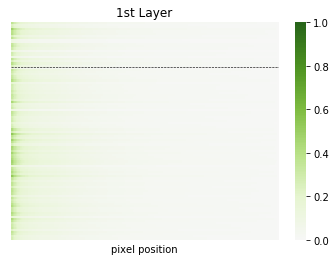

In [290]:
imgm1 = sns.heatmap(l1_m_sorted,xticklabels=False, yticklabels=False,center=0,cmap="PiYG")
imgm1.set(xlabel = "pixel position", ylabel = "") 
plt.title("1st Layer")
plt.plot(list(imgm1.get_xlim()), [21,21], 'k--', linewidth = 0.6)
#plt.yticks([13,36], ["4", "9"])
pass
plt.savefig('l1_m.jpg')